### IMPORTANDO AS BILIOTECAS NECESSÁRIAS

In [2]:
import os 
#Controlando o comportamento da biblioteca CUDA em Python
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import   numpy   as   np 
import   cv2 
import   matplotlib.pyplot   as   plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

### CHECANDO A UTILIZAÇÃO DA PLACA DE VÍDEO

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


### LIMITANDO A GERAÇÃO DE NÚMEROS ALEATÓRIOS NOS TESTES

In [4]:
SEED = 42

np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### DEFININDO OS DIRETÓRIOS DO DATASET

In [5]:
DATA_DIR = '/home/jocsan/SegNet-Tutorial/CamVid'

In [6]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

### DEFININDO A FUNÇÃO AUXILIAR PARA VIZUALIZAÇÃO DE DADOS

In [7]:
#Função auxiliar para visualização de dados 
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### CRIANDO A CLASSE "DATASET" PARA ORGANIZAR OS DADOS

In [8]:
class Dataset(BaseDataset):
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, #Expansão de dados
            preprocessing=None,
    ):  
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        ##Converte nomes de str em valores de classe em máscaras
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
           
    
    def __getitem__(self, i):
        
        ##Lendo dados
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        ##Extrai certas classes da máscara (por exemplo, carros)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
         
        #Aplicar aumentos
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        
        #Aplicar pré-processamento
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)


### VISUALIZANDO OS DADOS QUE TEMOS ATÉ O MOMENTO

In [9]:
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

-------------------------------------------------- sky --------------------------------------------------


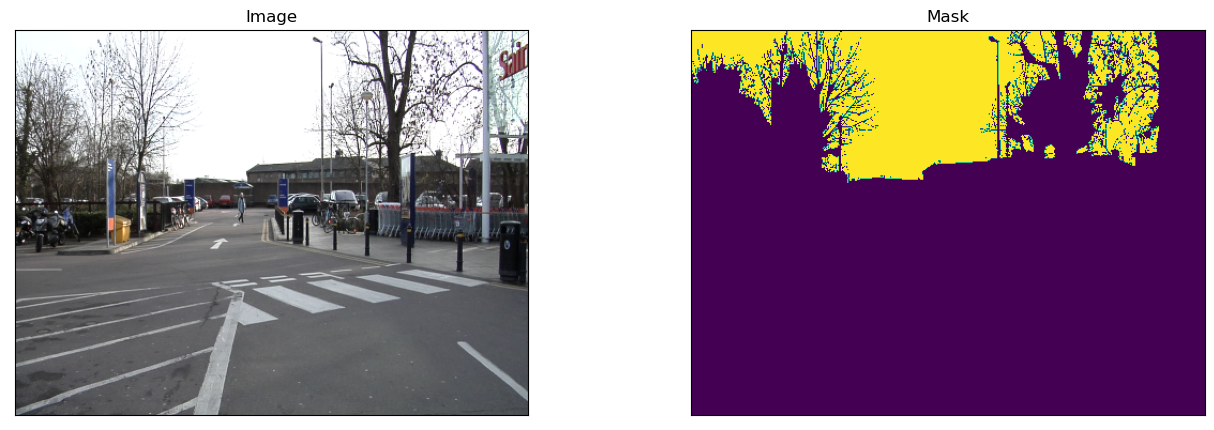

-------------------------------------------------- building --------------------------------------------------


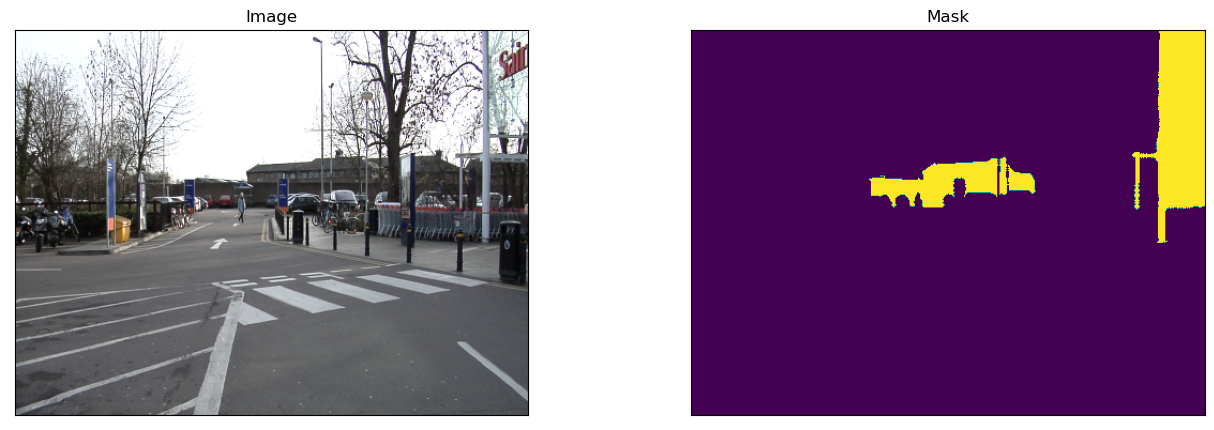

-------------------------------------------------- pole --------------------------------------------------


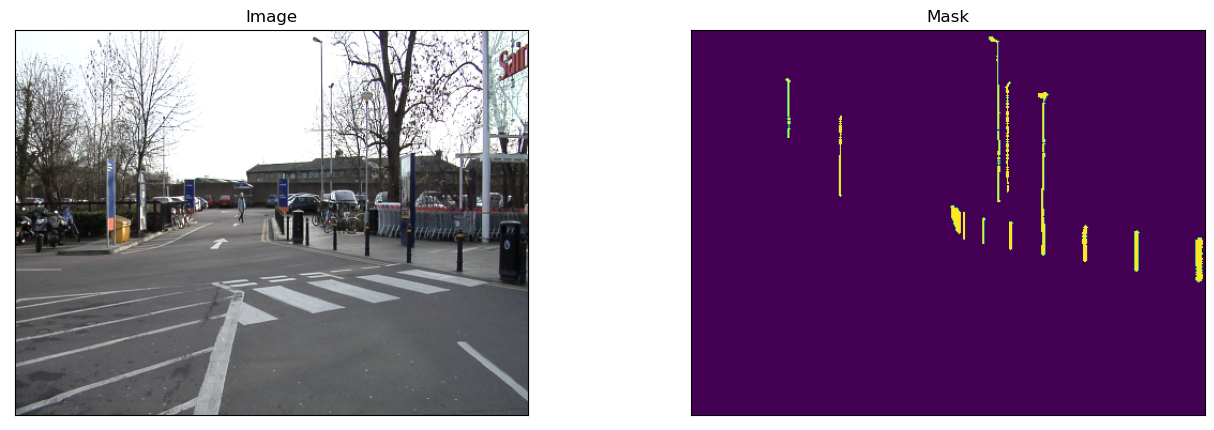

-------------------------------------------------- road --------------------------------------------------


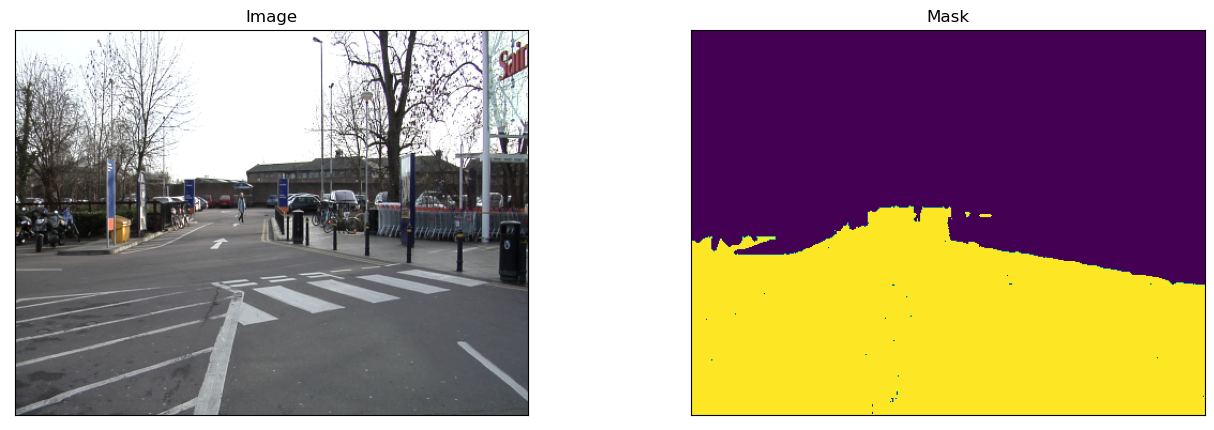

-------------------------------------------------- pavement --------------------------------------------------


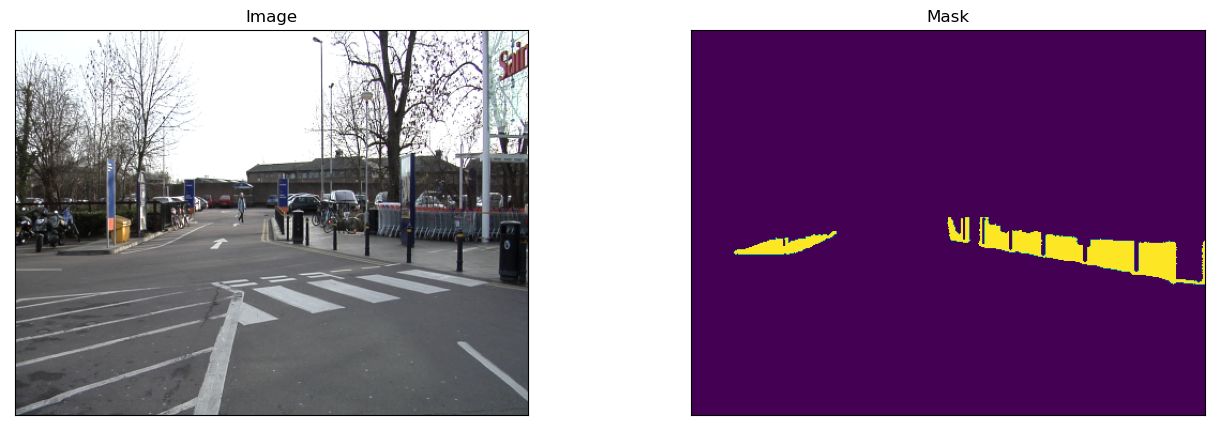

-------------------------------------------------- tree --------------------------------------------------


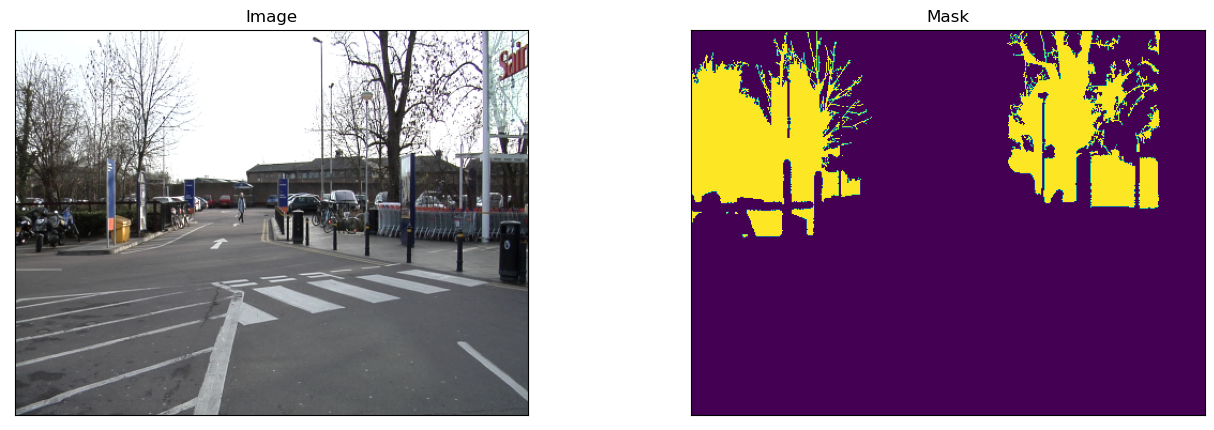

-------------------------------------------------- signsymbol --------------------------------------------------


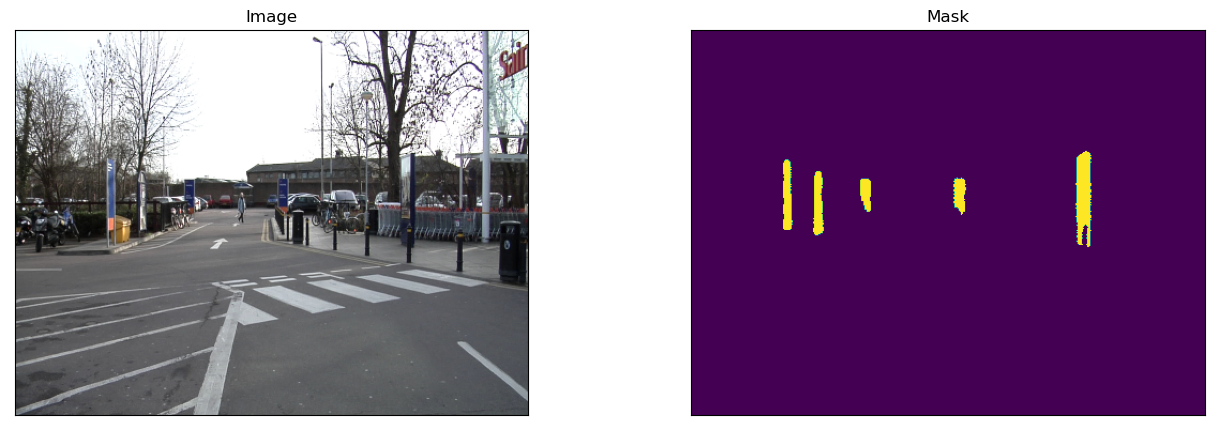

-------------------------------------------------- fence --------------------------------------------------


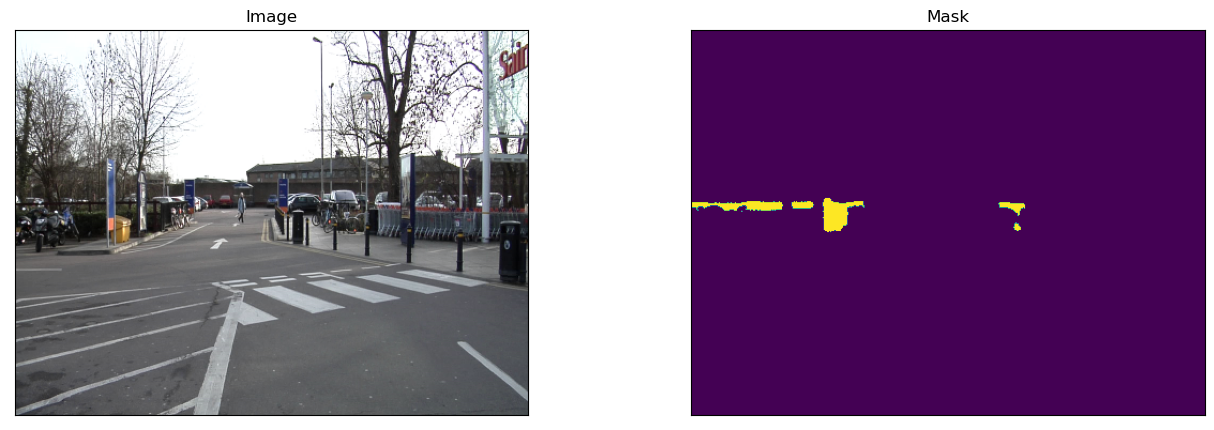

-------------------------------------------------- car --------------------------------------------------


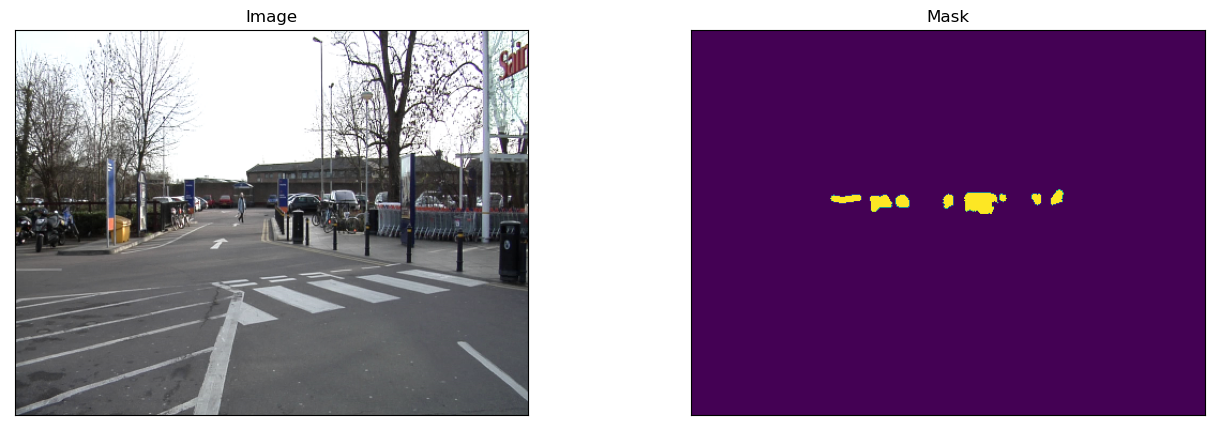

-------------------------------------------------- pedestrian --------------------------------------------------


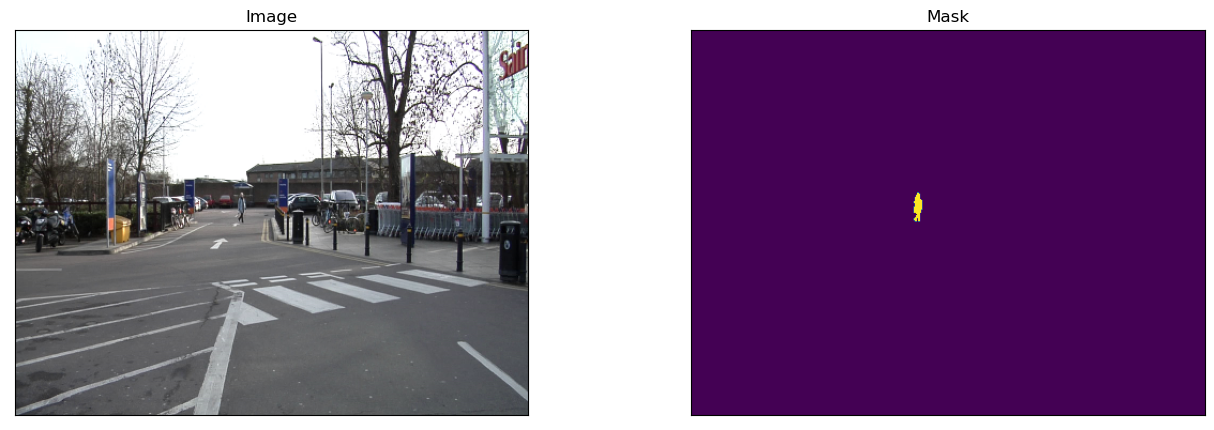

-------------------------------------------------- bicyclist --------------------------------------------------


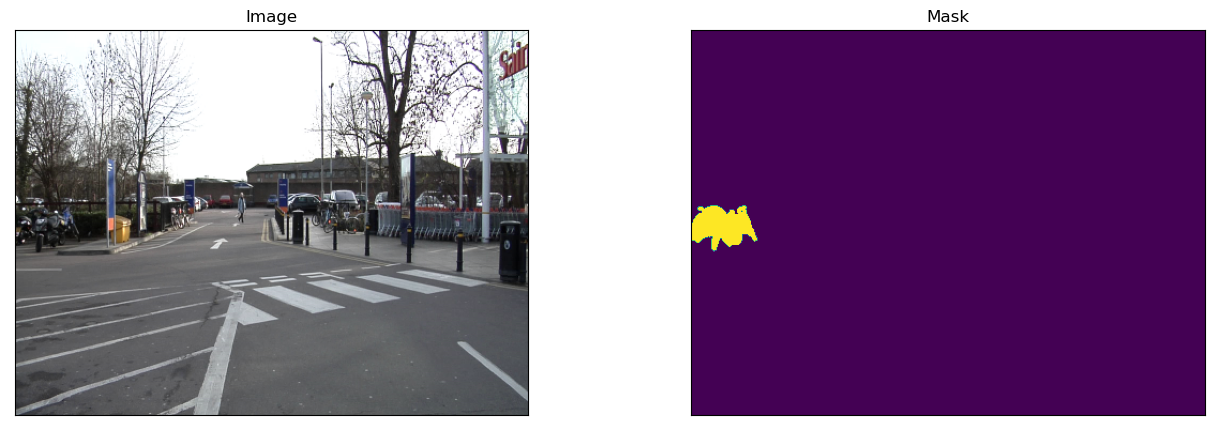

-------------------------------------------------- unlabelled --------------------------------------------------


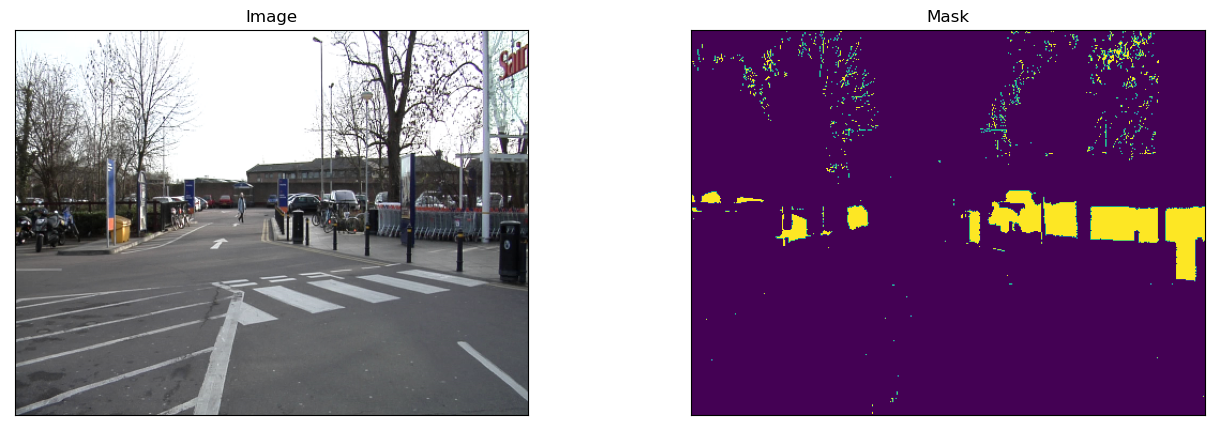

In [11]:
for teste in CLASSES:
    i = 1
    dataset = Dataset(x_train_dir, y_train_dir, classes=[teste])
    image, mask = dataset[i]
    
    linha = '-'*50
    print(linha, teste, linha)
    
    visualize(
        Image=image, 
        Mask=mask.squeeze(),
    )
    

### AUMENTO DE DADOS COM A BIBLIOTECA "ALBUMENTATIONS"

In [12]:
import albumentations as albu

In [13]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """"Adicione preenchimentos para tornar a forma da imagem divisível por 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construir transformação de pré-processamento
    
    Argumentos:
        preprocessing_fn (callbale): função de normalização de dados
            (pode ser específico para cada rede neural pré-treinada)
    Retornar:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

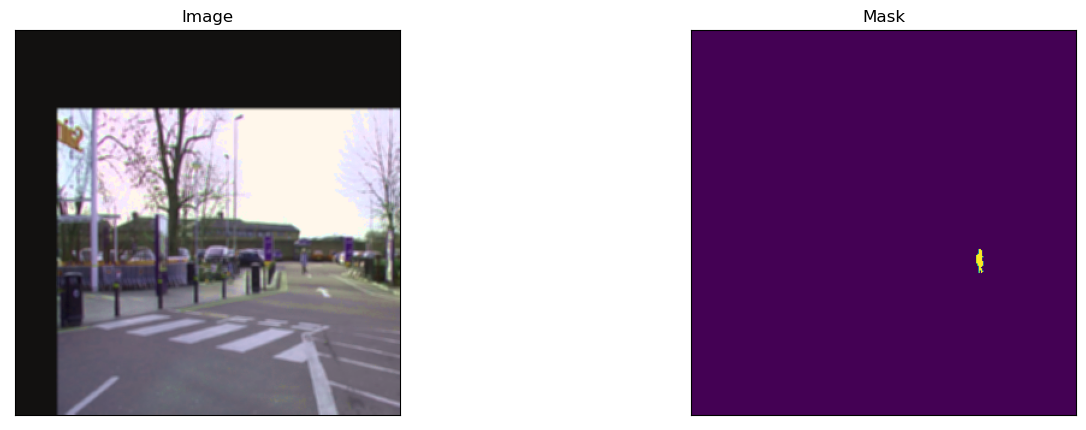

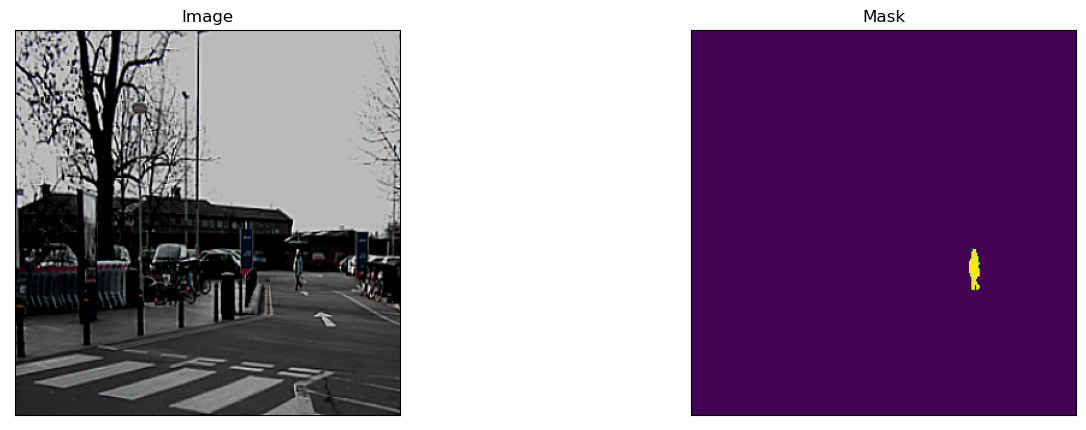

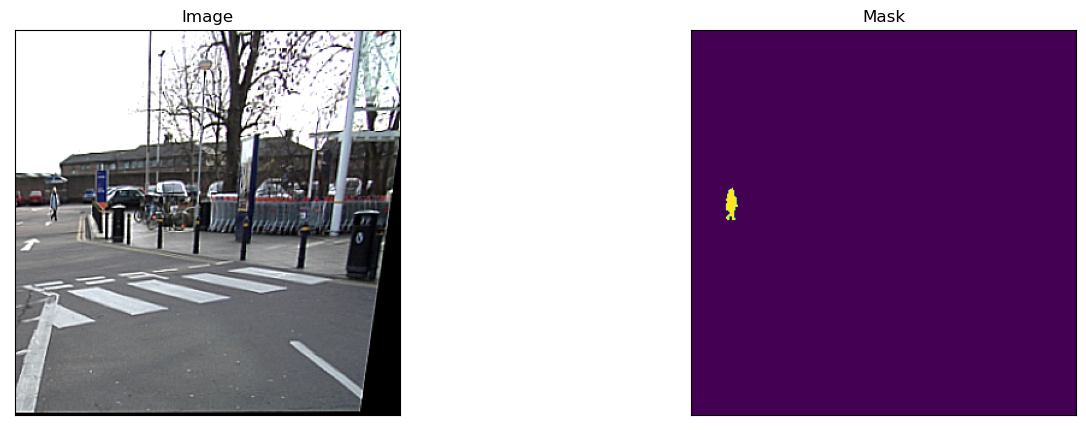

In [48]:
#Visualizar imagens e máscaras aumentadas

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['pedestrian'],
)

#Mesma imagem com diferentes transformações aleatórias
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

### Resolvendo o erro "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed"

In [29]:
import urllib.request
import ssl

def main():
    ssl._create_default_https_context = ssl._create_unverified_context
    r = urllib.request.urlopen('http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth')
    print(r.status)
    print(r)

if __name__ == '__main__':
    main()

200


### CRIANDO O MODELO E TREINANDO

In [30]:
ENCODER = 'se_resnext50_32x4d'#Modelo de rede neural convolucional (CNN) 
ENCODER_WEIGHTS = 'imagenet'  #Parâmetro para especificar os pesos pré-treinados a serem usados no codificador
CLASSES = ['car']             #Classe escolhida para ser segmentada na imagem
ACTIVATION = 'sigmoid'        #Pode ser None para logits ou 'softmax2d' para segmentação multiclasse
DEVICE = 'cuda'               #Dispositivo CUDA em utilização

#Criar modelo de segmentação com codificador pré-treinado
model = smp.FPN(
    encoder_name=ENCODER,                    #Codificador, por exemplo mobilenet_v2 ou eficientenet-b7
    encoder_weights=ENCODER_WEIGHTS,         #Pesos pré-treinados `imagenet` para inicialização do codificador
    in_channels=3,                           #Canais de entrada do modelo (1 para imagens em escala de cinza, 3 para RGB, etc.)
    classes=len(CLASSES),                    #Canais de saída do modelo (número de classes em seu conjunto de dados)
    activation=ACTIVATION,
)
#Obtendo a função de pré-processamento adequada para codificador
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [31]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')

In [32]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/home/jocsan/anaconda3/envs/teste2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [33]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [34]:
# criar corredores de época
# é um loop simples de iteração sobre as amostras do carregador de dados

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### CRIANDO O MODELO DE TREINO PARA N ÉPOCAS

In [49]:
max_score = 0

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    #Salvar modelo, alterar lr, etc.
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.00it/s, dice_loss - 0.1969, iou_score - 0.7159]
Model saved!

Epoch: 1
valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.00it/s, dice_loss - 0.2555, iou_score - 0.651]

Epoch: 2
valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.01it/s, dice_loss - 0.2093, iou_score - 0.71]

Epoch: 3
valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 10.92it/s, dice_loss - 0.2295, iou_score - 0.688]

Epoch: 4
valid: 100%|█████████████████████████████████████████████████████████████████████████████

valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.13it/s, dice_loss - 0.2602, iou_score - 0.6524]

Epoch: 19
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.12it/s, dice_loss - 0.1975, iou_score - 0.7235]

Epoch: 20
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.13it/s, dice_loss - 0.1922, iou_score - 0.7258]

Epoch: 21
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.12it/s, dice_loss - 0.1863, iou_score - 0.7344]

Epoch: 22
valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████

valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.14it/s, dice_loss - 0.1583, iou_score - 0.7618]

Epoch: 38
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.10it/s, dice_loss - 0.1618, iou_score - 0.7592]

Epoch: 39
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.14it/s, dice_loss - 0.1625, iou_score - 0.7594]

Epoch: 40
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.11it/s, dice_loss - 0.1553, iou_score - 0.7636]

Epoch: 41
valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████

valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.10it/s, dice_loss - 0.1649, iou_score - 0.7514]

Epoch: 56
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.08it/s, dice_loss - 0.1567, iou_score - 0.7602]

Epoch: 57
valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.12it/s, dice_loss - 0.16, iou_score - 0.7582]

Epoch: 58
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.10it/s, dice_loss - 0.1554, iou_score - 0.7626]

Epoch: 59
valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████

valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.12it/s, dice_loss - 0.1562, iou_score - 0.7644]

Epoch: 75
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.13it/s, dice_loss - 0.1527, iou_score - 0.7668]

Epoch: 76
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.13it/s, dice_loss - 0.1551, iou_score - 0.7652]

Epoch: 77
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.13it/s, dice_loss - 0.1588, iou_score - 0.7591]

Epoch: 78
valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████

valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.11it/s, dice_loss - 0.1563, iou_score - 0.7587]

Epoch: 93
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.07it/s, dice_loss - 0.1621, iou_score - 0.7548]

Epoch: 94
valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.13it/s, dice_loss - 0.1577, iou_score - 0.761]

Epoch: 95
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.12it/s, dice_loss - 0.1576, iou_score - 0.7617]

Epoch: 96
valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████

In [70]:
iou_scores.append(valid_logs['iou_score'])
accuracy = sum(iou_scores) / len(iou_scores)
print(f'Acurácia média (iou_score): {accuracy}')

Acurácia média (iou_score): 0.7607738015675307


In [73]:
from sklearn.metrics import confusion_matrix
import torch

max_score = 0
y_true = []
y_pred = []

for i in range(0, 1):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # Registrar rótulos verdadeiros e previsões
    y_true.extend(CLASSES)  # Substitua com seus próprios rótulos verdadeiros
    y_pred.extend(Mask)   # Substitua com suas próprias previsões

    # Salvar modelo, alterar lr, etc.
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

# Calcule a matriz de confusão usando scikit-learn
confusion = confusion_matrix(y_true, y_pred)

# A matriz de confusão será uma matriz apropriada para o seu problema de classificação
print("Matriz de Confusão:")
print(confusion)


Epoch: 0
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:09<00:00, 11.09it/s, dice_loss - 0.1704, iou_score - 0.7427]


NameError: name 'Mask' is not defined

### CARREGANDO O MELHOR MODELO SALVO

In [50]:
best_model = torch.load('./best_model.pth')

### CRIANDO O TESTE E AVALIANDO O MODELO

In [51]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [52]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [00:25<00:00,  9.12it/s, dice_loss - 0.1829, iou_score - 0.753]


### CONJUNTO DE DADOS DE TESTE SEM TRANSFORMAÇÕES, PARA VISUALIZAÇÃO DAS IMAGENS 

In [53]:
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

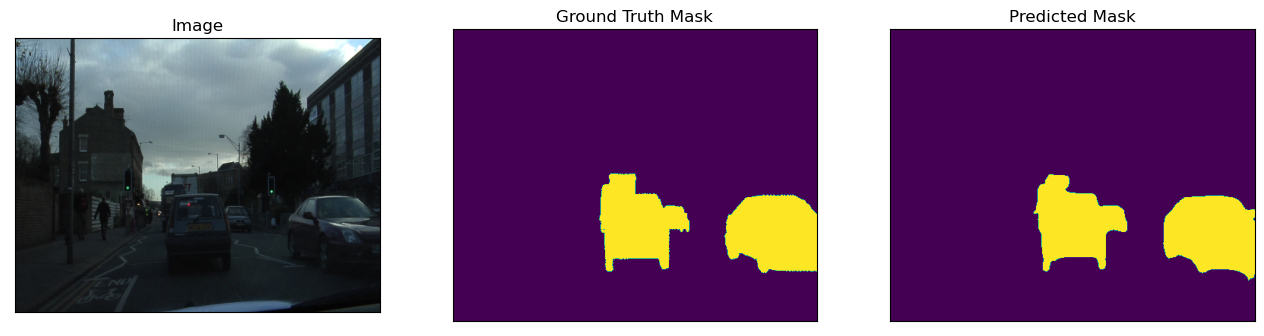

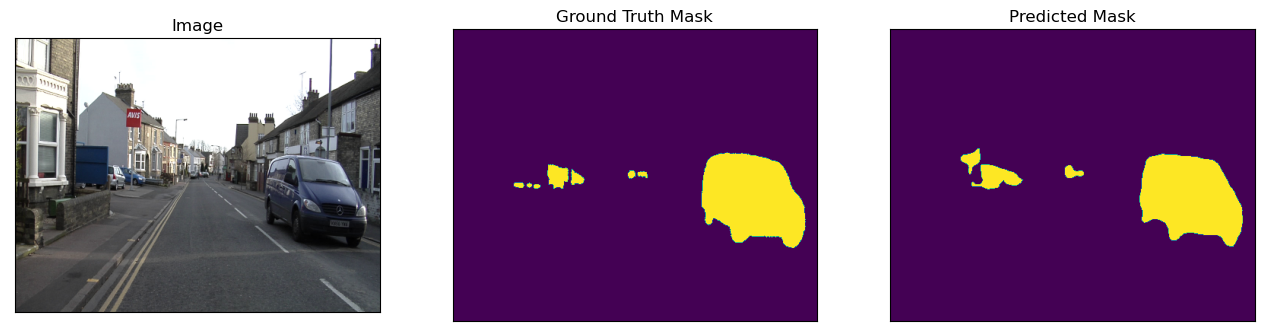

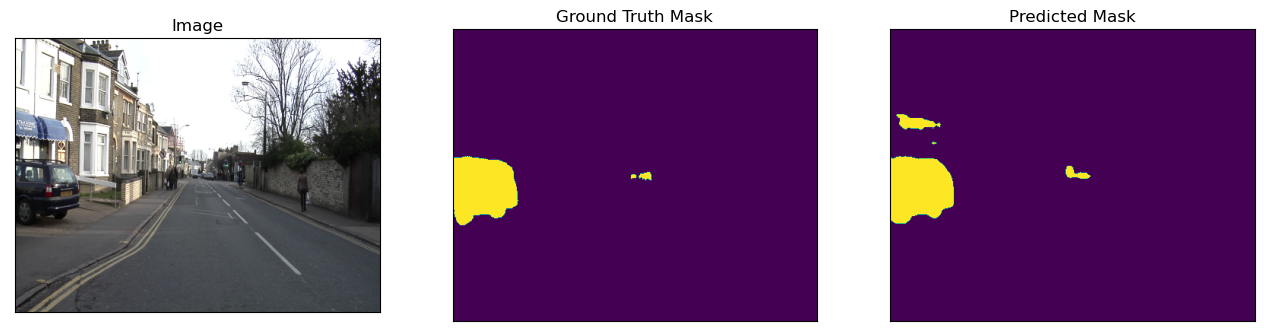

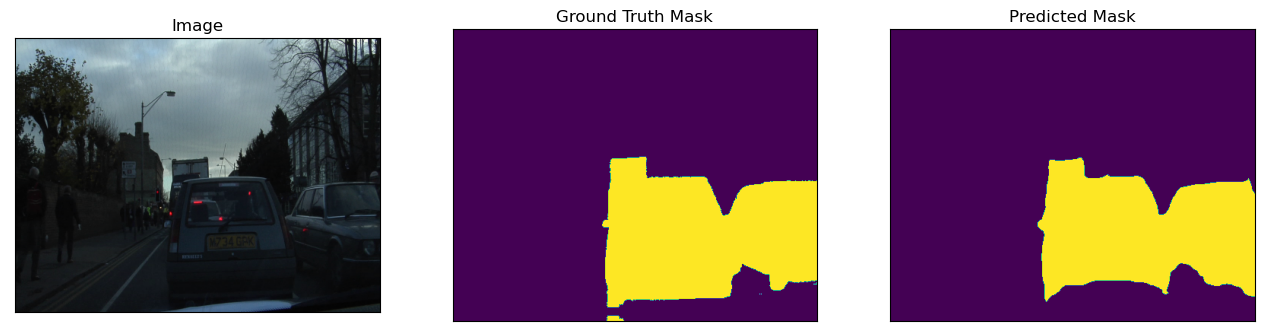

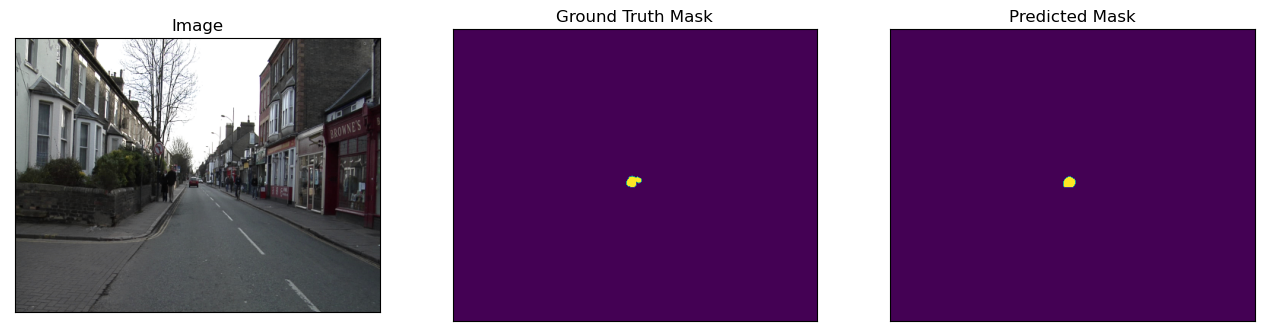

In [54]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [74]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Listas para armazenar rótulos verdadeiros e previsões
true_labels = []
predicted_labels = []

for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    # Converter máscaras para rótulos (classes)
    true_labels.extend(gt_mask.flatten())
    predicted_labels.extend(pr_mask.flatten())

# Calcular a matriz de confusão
confusion = confusion_matrix(true_labels, predicted_labels)

# A matriz de confusão conterá as contagens de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos para cada classe.
print("Matriz de Confusão:")
print(confusion)

Matriz de Confusão:
[[869955   1170]
 [  3393  47082]]


In [99]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Exemplo de mapeamento de classes para números (substitua pelos seus próprios valores)
class_mapping = {
    "sky": 0,
    "building": 1,
    "pole": 2,
    "road": 3,
    "pavement": 4,
    "tree": 5,
    "signsymbol": 6,
    "fence": 7,
    "car": 8,
    "pedestrian": 9,
    "bicyclist": 10,
    "unlabelled": 11
}

# Substitua true_labels e predicted_labels pelos seus próprios dados
true_labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])  # Exemplo de máscara verdadeira
predicted_labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])  # Exemplo de previsão do modelo

# Calcular a matriz de confusão
confusion = confusion_matrix(true_labels, predicted_labels)

# A matriz de confusão mostrará o desempenho do modelo para cada classe
print("Matriz de Confusão:")
print(confusion)

Matriz de Confusão:
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]]


In [78]:
#Definir os valores da matriz de confusão
TP = 1  # Verdadeiros positivos
TN = 11  # Verdadeiros negativos (para todas as classes)
FP = 0  # Falsos positivos
FN = 0  # Falsos negativos

# Calcular a acurácia
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calcular a precisão
precision = TP / (TP + FP)

# Calcular o recall (sensibilidade)
recall = TP / (TP + FN)

# Calcular o F1-score
precision = TP / (TP + FP)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')

Acurácia: 1.00
Precisão: 1.00
Recall: 1.00
F1-score: 1.00
